In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely import geometry
import pyogrio
from IPython.display import Image

In [2]:
import warnings
warnings.filterwarnings('ignore')

# (1) Census data processing

Perform necessary calculations on census data to get % rates
</br>-Population
</br>-Median net/disposable income
</br>-% employed/unemployed/retired/studying
</br>-% working outside of area
</br>-% commute method

In [3]:
# import 2021 census files
workforce_census_filepath = "data/census/insee_work-census_2021/base-ic-activite-residents-2021.xlsx"
netincome_census_filepath = "data/census/insee_net-income_2021/BASE_TD_FILO_IRIS_2021_DEC.xlsx"
disposableincome_census_filepath = "data/census/insee_disposable-income_2021/BASE_TD_FILO_IRIS_2021_DISP.xlsx"
workforce_census = pd.read_excel(workforce_census_filepath, sheet_name='IRIS')
netincome_census = pd.read_excel(netincome_census_filepath, sheet_name='IRIS')
disposableincome_census = pd.read_excel(disposableincome_census_filepath, sheet_name='IRIS')

In [4]:
### COMPUTE DATA VARIABLES FOR SPATIAL ANALYSIS BY IRIS CENSUS NEIGHBORHOOD ###
wf_df = workforce_census.copy()
ni_df = netincome_census.copy()
di_df = disposableincome_census.copy()
# Define variables
rate_definitions = {
    "unemployment_rate": ("P21_CHOM1564", "P21_ACT1564"),
    "employed_rate": ("P21_ACTOCC1564", "P21_ACT1564"),
    "studying_rate": ("P21_ETUD1564", "P21_ACT1564"),
    "retired_rate": ("P21_RETR1564", "P21_POP1564"),
    "work_local": ("P21_ACTOCC15P_ILT1", "P21_ACTOCC1564"),
    "work_diffcommune_samearr": ("P21_ACTOCC15P_ILT2P", "P21_ACTOCC1564"),
    "work_diffcommune_samedept": ("P21_ACTOCC15P_ILT2", "P21_ACTOCC1564"),
    "work_diffcommune_diffdept_sameregion": ("P21_ACTOCC15P_ILT3", "P21_ACTOCC1564"),
    "work_diffregion": ("P21_ACTOCC15P_ILT4", "P21_ACTOCC1564"),
    "work_diffcountry_": ("P21_ACTOCC15P_ILT5", "P21_ACTOCC1564"),
    "commute_notransport": ("C21_ACTOCC15P_PAS", "P21_ACTOCC1564"),
    "commute_walk": ("C21_ACTOCC15P_MAR", "P21_ACTOCC1564"),
    "commute_bicycle": ("C21_ACTOCC15P_VELO", "P21_ACTOCC1564"),
    "commute_motorcycle": ("C21_ACTOCC15P_2ROUESMOT", "P21_ACTOCC1564"),
    "commute_vehicle": ("C21_ACTOCC15P_VOIT", "P21_ACTOCC1564"),
    "commute_publictransport": ("C21_ACTOCC15P_TCOM", "P21_ACTOCC1564"),
}

# calculate rates as percentage of IRIS population
def add_rate_columns(df, rate_dict):
    for new_col, (num, denom) in rate_dict.items():
        df[new_col] = (df[num] / df[denom].replace(0, pd.NA)) * 100
    return df
wf_df = add_rate_columns(wf_df, rate_definitions)

# merge median net income into workforce census table
wf_df = wf_df.merge(ni_df[["IRIS", "DEC_MED21"]], on="IRIS", how="left")
# merge median disposable income into workforce census table
wf_df = wf_df.merge(di_df[["IRIS", "DISP_MED21"]], on="IRIS", how="left")

# rename columns
rename_map = {
    "P21_POP1564": "population",
    "DEC_MED21": "median_net_income",
    "DISP_MED21": "median_disposable_income",
    "IRIS": "INSEE_IRIS_ID"
}
wf_df = wf_df.rename(columns=rename_map)

# keep only columns of interest
rename_map.update({v[0]: k for k, v in rate_definitions.items()})
wf_df = wf_df[list(rename_map.values())]

# reorder dataframe columns
reorder_cols_list = ['INSEE_IRIS_ID', 'population', 'median_net_income',
 'median_disposable_income', 'unemployment_rate',
 'employed_rate',
 'studying_rate',
 'retired_rate',
 'work_local',
 'work_diffcommune_samearr',
 'work_diffcommune_samedept',
 'work_diffcommune_diffdept_sameregion',
 'work_diffregion',
 'work_diffcountry_',
 'commute_notransport',
 'commute_walk',
 'commute_bicycle',
 'commute_motorcycle',
 'commute_vehicle',
 'commute_publictransport']
wf_df = wf_df[reorder_cols_list]

# convert string values in income columns to NaNs and round down population due to being floats (likely due to being a population estimate rather than a direct count)
wf_df["median_net_income"] = pd.to_numeric(wf_df["median_net_income"], errors="coerce")
wf_df["median_disposable_income"] = pd.to_numeric(wf_df["median_disposable_income"], errors="coerce")
wf_df["population"] = wf_df["population"].round().astype("Int64")

# save as new excel file
wf_df.to_excel("data/census/INSEE_census_2021.xlsx", index=False)

# show final dataframe
wf_df

,INSEE_IRIS_ID,population,median_net_income,median_disposable_income,unemployment_rate,employed_rate,studying_rate,retired_rate,work_local,work_diffcommune_samearr,work_diffcommune_samedept,work_diffcommune_diffdept_sameregion,work_diffregion,work_diffcountry_,commute_notransport,commute_walk,commute_bicycle,commute_motorcycle,commute_vehicle,commute_publictransport
0,010010000,509,NaN,NaN,6.505535,93.494465,8.167972,7.744545,12.399781,88.830062,61.050549,24.547435,3.232078,0.0,4.984068,0.0,0.0,2.524759,102.973134,1.229844
1,010020000,163,NaN,NaN,1.649213,98.350787,14.145126,5.216707,17.785689,84.390547,73.09595,7.521109,3.773487,0.0,3.701542,0.0,0.0,0.0,80.666181,3.589818
2,010040101,1185,19330.0,20350.0,7.92546,92.07454,18.449277,3.222112,48.275906,53.328093,34.012401,17.540009,1.775682,0.0,7.723165,8.530443,2.696495,1.194611,76.568643,13.026165
3,010040102,2418,16830.0,18570.0,19.221104,80.778896,10.447223,4.038371,40.718848,60.514882,42.38568,17.019818,0.80922,0.300164,5.567385,9.340548,0.707352,1.962189,64.420833,16.779493
4,010040201,2649,19940.0,20700.0,14.209538,85.790462,9.83998,4.862404,43.293218,57.75102,41.386358,15.17145,1.193212,0.0,2.168272,12.58787,4.187983,0.862303,71.029556,14.784575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49275,974240101,1022,12030.0,14870.0,32.130744,67.869256,10.380073,5.032276,83.123301,18.012037,17.559771,0.0,0.452266,0.0,5.631322,29.533812,2.291124,0.0,65.094651,1.10866
49276,974240102,1081,10660.0,14230.0,36.044573,63.955427,9.113442,2.739557,83.756774,17.496079,17.496079,0.0,0.0,0.0,4.231377,15.917647,1.078749,0.0,65.981036,3.111633
49277,974240103,473,NaN,NaN,34.725478,65.274522,9.537947,2.463522,74.586819,26.378474,24.466923,0.0,1.911551,0.0,2.397027,11.830096,2.365857,0.0,84.100254,2.365857
49278,974240104,671,NaN,NaN,42.095045,57.904955,9.798959,3.131442,70.045529,32.042755,31.696986,0.0,0.34577,0.0,1.845775,14.152679,3.573399,0.0,62.099736,12.471218


## Variable Definitions
#### population
"P21_POP1564"

#### number active
"P21_ACT1564"

#### number unemployed
"P21_CHOM1564"

#### number employed
"C21_ACTOCC15P"

#### number studying
"P21_ETUD1564"

#### number retired
"P21_RETR1564"

#### work location
"P21_ACTOCC15P_ILT1" # number working in commune of residence
"P21_ACTOCC15P_ILT2P" # number working in a different commune
"P21_ACTOCC15P_ILT2" # number working in a different commune but in the same department as residence
"P21_ACTOCC15P_ILT3" # number working in a different commune & different department but in the same region as residence
"P21_ACTOCC15P_ILT4" # number working in a different region of France
"P21_ACTOCC15P_ILT5" # number working in a different country than France

#### commute method
"C21_ACTOCC15P_PAS" # number who do not use any transport for work
"C21_ACTOCC15P_MAR" # number commuting by walking
"C21_ACTOCC15P_VELO" # number commuting by bicycling
"C21_ACTOCC15P_2ROUESMOT" # number commuting by moped/scooter/motorcycle
"C21_ACTOCC15P_VOIT" # number commuting by car
"C21_ACTOCC15P_TCOM" # number commuting by public transport

#### income
"DEC_MED21" # median net income per capita
"DISP_MED21" # median disposable income per capita

# (2) Admin Boundaries merge

Preparing the administrative boundaries for spatial analysis and choropleth maps
</br>-In communes layer, replace Paris polygon with 20 Paris arrondissements; and replace arr code with comm code
</br>-Generate new communes geojson [Communes_iledefrance_with_parisarrs.geojson]
</br>-Combine all administrative layers into single geopackage [admin_polygons_allayers.gpkg]
</br>-Spatial Join associated Region, Department, Arrondissement, and Commune for each IRIS; for Arrondissements will need to handle IRIS that are in multiple Arrondissements with overlay intersection
</br>-Compute centroid for each IRIS (EPSG:2154)
</br>-Output as final geopackage to use for future spatial joins and choropleths [IRIS_with_RegDepCommArr.gpkg]


In [5]:
# import data
reg_path = "data/boundaries/individual_layers/Regions_iledefrance.geojson"
dept_path = "data/boundaries/individual_layers/Departements_iledefrance.geojson"
arrs_path = "data/boundaries/individual_layers/Arrondissements_iledefrance.geojson"
parisarrs_path = "data/boundaries/individual_layers/Arrondissements_paris.geojson"
comm_path = "data/boundaries/individual_layers/Communes_iledefrance.geojson"
iris_path = "data/boundaries/individual_layers/IRIS_iledefrance.geojson"
reg_gdf = gpd.read_file(reg_path).to_crs(epsg=2154)
dept_gdf = gpd.read_file(dept_path).to_crs(epsg=2154)
arrs_gdf = gpd.read_file(arrs_path).to_crs(epsg=2154)
parisarrs_gdf = gpd.read_file(parisarrs_path).to_crs(epsg=2154)
comm_gdf = gpd.read_file(comm_path).to_crs(epsg=2154)
iris_gdf = gpd.read_file(iris_path).to_crs(epsg=2154)

In [6]:
### HANDLE CENTRAL PARIS ARRONDISSEMENT POLYOGN MISMATCH ###
parisarrs_comm_aligned = parisarrs_gdf.copy()
# add any missing columns that exist in comm_gdf but not in parisarrs_gdf
for col in comm_gdf.columns:
    if col not in parisarrs_comm_aligned.columns:
        parisarrs_comm_aligned[col] = pd.NA

# reorder to match comm_gdf exactly
parisarrs_comm_aligned = parisarrs_comm_aligned[comm_gdf.columns]
# Paris department and region codes
parisarrs_comm_aligned["INSEE_DEP"] = "75"
parisarrs_comm_aligned["INSEE_REG"] = "11"
# Arrondissement code comes from INSEE_ARM if available
if "INSEE_ARM" in parisarrs_gdf.columns:
    parisarrs_comm_aligned["INSEE_ARR"] = parisarrs_gdf["INSEE_ARM"]
# For any missing arrondissement code, fill with NA explicitly
parisarrs_comm_aligned["INSEE_ARR"] = parisarrs_comm_aligned["INSEE_ARR"].fillna(pd.NA)
# Set column STATUT to "arrondissement"
parisarrs_comm_aligned["STATUT"] = "arrondissement"
# save communes without Paris communes
comm_gdf_no_paris = comm_gdf[comm_gdf["INSEE_DEP"] != "75"].copy()
# save new communes with arrondissements
comm_gdf_merged = gpd.GeoDataFrame(pd.concat([comm_gdf_no_paris, parisarrs_comm_aligned], ignore_index=True), crs=comm_gdf.crs)
# Replace INSEE_COM code with code from arrondissement
comm_gdf_merged.loc[comm_gdf_merged['INSEE_COM'] == "75056", 'INSEE_COM'] = comm_gdf_merged.loc[comm_gdf_merged['INSEE_COM'] == "75056", 'INSEE_ARR']
# set correct crs for future calculations (should already be EPSG:2154 but doublecheck to be sure)
comm_gdf_merged.set_crs(epsg=2154)
# save to new geojson file
comm_gdf_merged.to_file("data/boundaries/individual_layers/Communes_iledefrance_with_parisarrs.geojson", driver="GeoJSON")

Layers found: ['regions', 'departements', 'arrondissements', 'communes', 'iris']


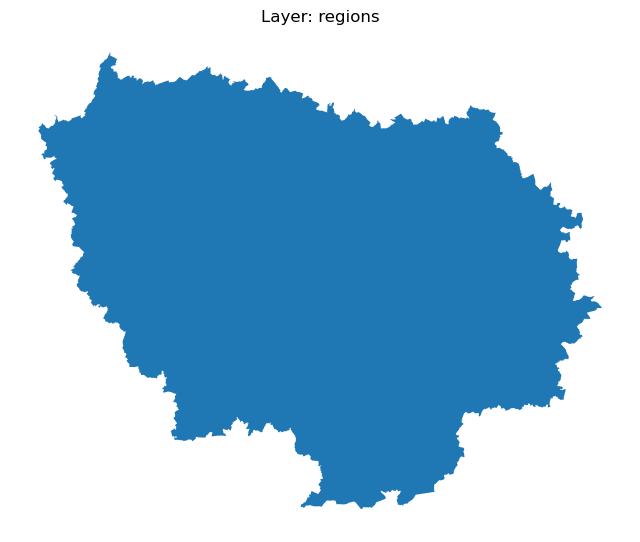

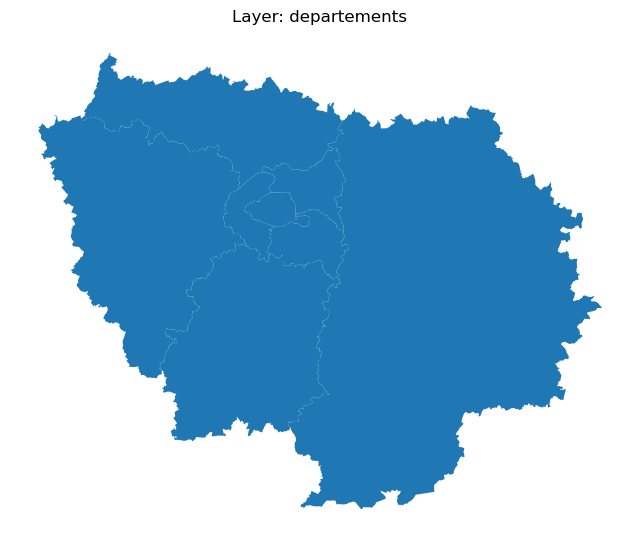

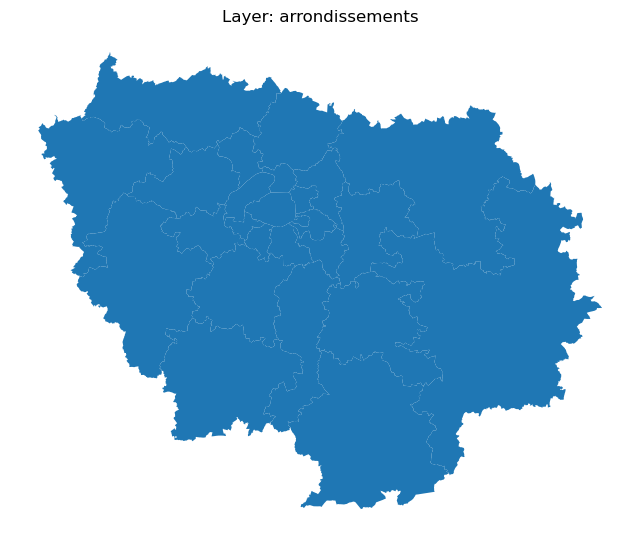

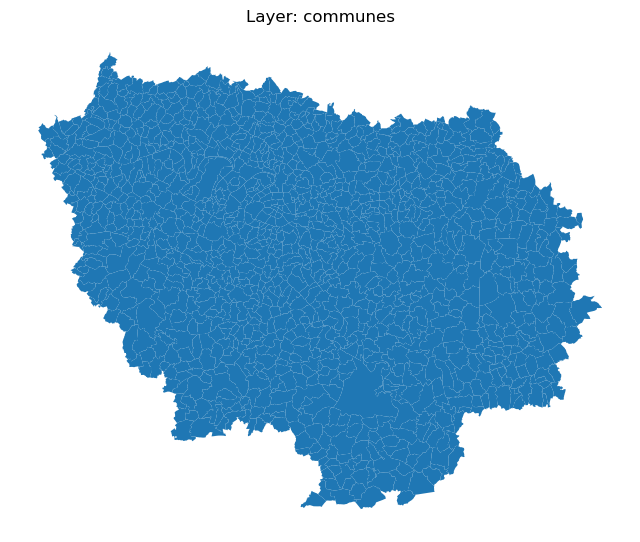

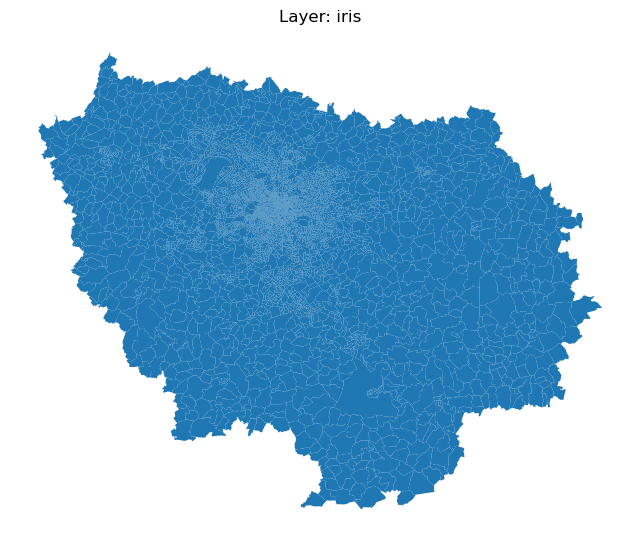

In [7]:
#### SAVE INTO SINGLE GEOPACKAGE ###
# Map variable names to desired layer names
layers = {
    "regions": reg_gdf,
    "departements": dept_gdf,
    "arrondissements": arrs_gdf,
    "communes": comm_gdf_merged,
    "iris": iris_gdf
}
# Loop through and write each as a separate layer into a single geopackage
for i, (layer_name, gdf) in enumerate(layers.items()):
    gdf.to_file("data/boundaries/admin_polygons_alllayers.gpkg", layer=layer_name, driver="GPKG")

# visualize different administrative polygons
gpkg_path = "data/boundaries/admin_polygons_alllayers.gpkg"
# List all layers using pyogrio
layers_info = pyogrio.list_layers(gpkg_path)
layer_names = [l[0] for l in layers_info]
print("Layers found:", layer_names)
# Plot each layer separately
for layer in layer_names:
    gdf = gpd.read_file(gpkg_path, layer=layer)
    gdf.plot(figsize=(8, 8))
    plt.title(f"Layer: {layer}")
    plt.axis("off")
    plt.show()

In [8]:
### BRING OVER UNIQUE IDENTIFIERS ###
# add ile-de-france region code to every IRIS
iris_with_Reg = iris_gdf.copy()
iris_with_Reg["INSEE_REG"] = "REGION_FXX_0000000000001"

# thankfully commune code is already present in IRIS table, but we can bring over the department code
iris_with_RegDepComm = iris_with_Reg.merge(comm_gdf_merged[["INSEE_COM", "INSEE_DEP"]], on="INSEE_COM", how="left")
# add in the department name
iris_with_RegDepComm = iris_with_RegDepComm.merge(dept_gdf[["INSEE_DEP", "NOM_DEP"]], on="INSEE_DEP", how="left")
# add missing department information for 11 IRISs missing departments
iris_with_RegDepComm.loc[iris_with_RegDepComm["INSEE_COM"] == "93059", ["INSEE_DEP", "NOM_DEP"]] = ["93", "Seine-Saint-Denis"]
iris_with_RegDepComm.loc[iris_with_RegDepComm["INSEE_COM"] == "95282", ["INSEE_DEP", "NOM_DEP"]] = ["95", "Val-d'Oise"]
iris_with_RegDepComm.loc[iris_with_RegDepComm["INSEE_COM"] == "60420", ["INSEE_DEP", "NOM_DEP"]] = ["60", "Oise"]
# rename Commune columns for future joins for higher regional choropleths
iris_with_RegDepComm = iris_with_RegDepComm.rename(columns={"CODE_IRIS": "INSEE_IRIS_ID", "INSEE_COM": "INSEE_COM_ID", "INSEE_DEP": "INSEE_DEP_ID"})
# rename arrondissement ID column to be added to IRIS table
arrs_gdf_forirismerge = arrs_gdf.rename(columns={"ID": "INSEE_ARR_ID", "NOM": "NOM_ARR"})
# compute intersections between IRIS and arrondissements
iris_arr_intersection = gpd.overlay(iris_with_RegDepComm[["INSEE_IRIS_ID", "geometry"]], arrs_gdf_forirismerge[["INSEE_ARR_ID", "NOM_ARR", "geometry"]], how="intersection")
# measure intersection area and pick the arrondissement covering the largest share of each IRIS
iris_arr_intersection["intersect_area"] = iris_arr_intersection.geometry.area
iris_arr_best = (iris_arr_intersection.sort_values("intersect_area", ascending=False).drop_duplicates(subset="INSEE_IRIS_ID"))
# merge that arrondissement information back into your IRIS dataset
iris_with_RegDepCommArr = iris_with_RegDepComm.merge(iris_arr_best[["INSEE_IRIS_ID", "INSEE_ARR_ID", "NOM_ARR"]], on="INSEE_IRIS_ID", how="left")
# rearrange columns
iris_with_RegDepCommArr =  iris_with_RegDepCommArr[['OBJECTID', 'TYP_IRIS', 'IRIS', 'INSEE_IRIS_ID', 'NOM_IRIS', 'INSEE_COM_ID', 'NOM_COM', 'INSEE_ARR_ID', 'NOM_ARR', 'INSEE_DEP_ID', 'NOM_DEP', 'INSEE_REG', 'geometry']]

In [9]:
### OUTPUT ###
# set correct crs for future calculations (should already be EPSG:2154 but doublecheck to be sure)
iris_with_RegDepCommArr.set_crs(epsg=2154)
# compute centroid of each IRIS
iris_centroids = iris_with_RegDepCommArr.copy()
iris_centroids["geometry"] = iris_centroids.geometry.centroid

# output centroids as seperate file
iris_centroids.to_file("data/boundaries/IRIS_centroids.gpkg", driver="GPKG")
# output final file to use for aggregated choropleths
iris_with_RegDepCommArr.to_file("data/boundaries/IRIS_with_RegDepCommArr.gpkg", driver="GPKG")

# (3) Compute travel time isochrone catchments

Calculate travel times to transit stations in Paris metro area
</br>-Acquire 1min isochrone increments for travel time on public transit from central station [TravelTime API]
</br>-Process and save each isochrone as geojson entity
</br>-Generate combined geopackage with all isochrone geojson layers [Paris_3hr_isochrones_combinedlayers.gpkg]
</br>-Assign travel time to each station within isochrone catchment areas 
</br>-Work from largest isochrone down to smallest to catch stations and assign travel times; catchment overwrites overwrites previous time entry based on station location in polygon hierarchy
</br>-Save stations data with travel time [Stations_with_traveltime.gpkg]

In [10]:
# import TravelTime API response text files
input_path = "data/transport/traveltime_api/api_responses_1-2-3hrs.txt"
# save api responses as variables
with open(input_path) as f:
    exec(f.read())

In [11]:
### gENERATE ISOCHRONE POLYGONS TO USE FOR TRAVEL TIME CATCHMENTS ###
# function to add minute and label properties to api data for later visualizations
def add_travel_time_properties(name, minutes, label):
    isochrone = eval(name)
    for feature in isochrone["features"]:
        feature["properties"]["travel_time_min"] = minutes
        feature["properties"]["travel_time_label"] = label
        
        feature["properties"].pop("search_id", None) # remove 'search_id' since they're all "0" from API

    return {"name": name, "travel_time_min": minutes, "travel_time_label": label, "data": isochrone}

# save list of isocrhone variable names
variable_names = [f"isochrone{i:03d}" for i in range(1, 181)]
# save list of travel times as integers
travel_times = list(range(1, 181))
# save list of travel time labels
travel_labels = [f"{i:03d}_min" for i in travel_times]

# save all data into dictionary
isochrone_dict = {name: add_travel_time_properties(name, minutes, label) for name, minutes, label in zip(variable_names, travel_times, travel_labels)}

In [12]:
### OUTPUT ###
# function to add minute and label properties to api data for later visualizations
def add_travel_time_properties(name, minutes, label):
    isochrone = eval(name)
    for feature in isochrone["features"]:
        feature["properties"]["travel_time_min"] = minutes
        feature["properties"]["travel_time_label"] = label
        
        feature["properties"].pop("search_id", None) # remove 'search_id' since they're all "0" from API

    return {"name": name, "travel_time_min": minutes, "travel_time_label": label, "data": isochrone}

# save list of isocrhone variable names
variable_names = [f"isochrone{i:03d}" for i in range(1, 181)]
# save list of travel times as integers
travel_times = list(range(1, 181))
# save list of travel time labels
travel_labels = [f"{i:03d}_min" for i in travel_times]
# save all data into dictionary
isochrone_dict = {name: add_travel_time_properties(name, minutes, label) for name, minutes, label in zip(variable_names, travel_times, travel_labels)}

# save all into one layer
# Collect all features into one GeoDataFrame
all_gdfs = []
for name, entry in isochrone_dict.items():
    gdf = gpd.GeoDataFrame.from_features(entry["data"]["features"], crs="EPSG:4326")
    gdf["travel_time_min"] = entry["travel_time_min"]
    gdf["travel_time_label"] = entry["travel_time_label"]
    gdf["layer_name"] = name
    all_gdfs.append(gdf)
# Combine into one GeoDataFrame
gdf_all = pd.concat(all_gdfs, ignore_index=True)
# order by travel time
gdf_all = gdf_all.sort_values("travel_time_min").reset_index(drop=True)
gdf_all.set_crs("EPSG:4326", inplace=True)
# save as one file
gpkg_output_path2 = "data/transport/traveltime_api/Paris_3hr_isochrones_combinedlayers.gpkg"
gdf_all.to_file(gpkg_output_path2, layer="all_isochrones", driver="GPKG")

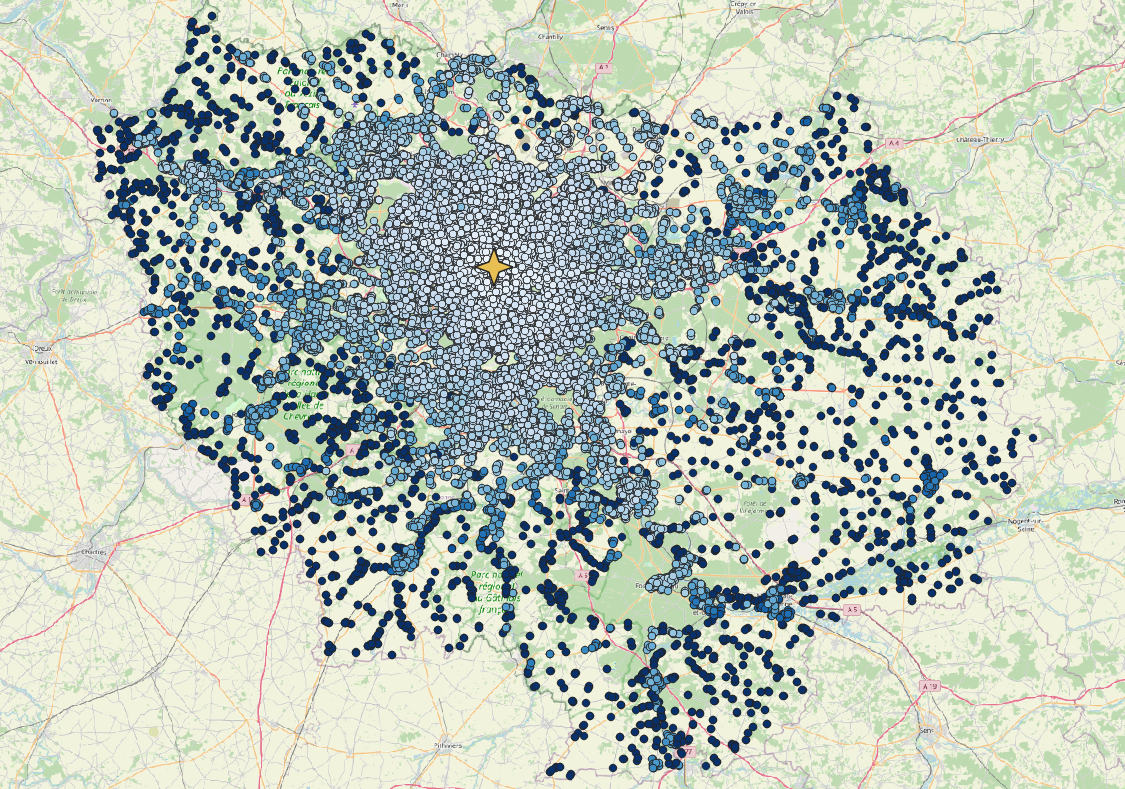

In [13]:
### ASSIGN TRAVEL TIME TO EACH STATION IN RATP NETWORK
# load isochrones
isochrones = gpd.read_file("data/transport/traveltime_api/Paris_3hr_isochrones_combinedlayers.gpkg").to_crs(epsg=2154)
# sort isochrones from largest to smallest (for containment assignment)
isochrones_sorted = isochrones.sort_values(by="travel_time_min", ascending=False)
# load stations
stations = gpd.read_file("data/transport/RATP/ratp_allstations.gpkg").to_crs(epsg=2154)
# set default travel time for all stations
stations["time_min"] = 181

# assign travel times by containment
for _, row in isochrones_sorted.iterrows():
    poly = row.geometry
    minute_val = int(row["travel_time_min"])
    mask = (stations.within(poly)) & (stations["time_min"] > minute_val)
    stations.loc[mask, "time_min"] = minute_val

# output to geopackage
gpkg_output_path = "data/transport/RATP/allstations_with_traveltime.gpkg"
stations.to_file(gpkg_output_path, driver="GPKG")

# visualize chronogramtic times for all stations in RATP network
Image(filename='data/transport/Paris_3hour_chronogram.png')

The chronograph map above shows the travel times assigned to each station as a function of distance in minutes from the central rail station of Paris, named "Chatelet-Les-Halles", which is considered the official central station of the city. Each isochrone layer represents one minute increments to over 3 hours of distance from the central station.

# (4) Transit Accessibility

Find which IRIS our stations are located in
</br>-Identify which IRIS each station belongs to / save IRIS code to each station
</br>-Record distance of closest station to IRIS centroid (calculate distance)
</br>-Calculate average walking time for each station to its IRIS centroid
Get basic information on transport accessibility per IRIS
</br>-Count stations in each IRIS
</br>-Calculate average walking time between IRIS centroid to all stations in IRIS
</br>-Save data on transport accessibility per IRIS []


In [14]:
### IMPORT PREPROCESSED DATA ###
#import IRIS
iris_data = gpd.read_file("data/boundaries/IRIS_with_RegDepCommArr.gpkg").to_crs(epsg=2154)
# import stations
stations_data = gpd.read_file("data/transport/RATP/allstations_with_traveltime.gpkg").to_crs(epsg=2154)

In [15]:
### COMPUTE NEAREST STATION TO IRIS CENTROIDS ###
### Find nearest station to IRIS centroids and calculate distance (in meters) and walk time (minutes)
# Dissolve multipart IRIS geometries to compute centroids for IRISs composed of multiple polygons
iris_dissolved = iris_data.dissolve(by="INSEE_IRIS_ID", as_index=False)
# Compute centroids and make them the active geometry
iris_centroids = iris_dissolved.copy()
iris_centroids = iris_centroids.set_geometry(iris_centroids.geometry.centroid)
iris_centroids = iris_centroids.set_crs(iris_dissolved.crs)  # ensure CRS carried over
# Nearest spatial join to add IRIS code to the station the IRIS centroid is nearest to
stations_nearestIRIS = gpd.sjoin_nearest(stations_data, iris_centroids[["INSEE_IRIS_ID", "geometry"]], how="left", distance_col="nearest_centroid_dist")
stations_nearestIRIS = stations_nearestIRIS.drop(columns=["index_right"])
# Nearest spatial join to add centroid-nearest stations to each IRIS
iris_with_station = gpd.sjoin_nearest(iris_centroids, stations_data[["arrid", "arrtype", "geometry"]], how="left", distance_col="nearest_station_dist")
iris_with_station = (iris_with_station.sort_values("nearest_station_dist", ascending=True).drop_duplicates(subset="INSEE_IRIS_ID", keep="first"))# Keep only the closest station per IRIS centroid
iris_with_station = iris_with_station.drop(columns=["index_right"])
# Calculate average walking time to closest station for each IRIS,in minutes, using 5km/hr average
stations_nearestIRIS["nearest_walk_time"] = stations_nearestIRIS["nearest_centroid_dist"] / 1.38889 / 60
iris_with_station["nearest_walk_time"] = iris_with_station["nearest_station_dist"] / 1.38889 / 60
# Add centroid-based calculations to original IRIS geodataframe
iris_with_centroids = iris_dissolved.merge(iris_with_station[["INSEE_IRIS_ID", "arrid", "arrtype", "nearest_station_dist", "nearest_walk_time"]], on="INSEE_IRIS_ID", how="left")

### COUNT STATIONS PER IRIS ###
# Perform spatial join to find which IRIS each station falls in
stations_in_iris = gpd.sjoin(stations_data, iris_with_centroids[["INSEE_IRIS_ID", "geometry"]], how="left", predicate="within")
# Count stations per IRIS
station_counts = (stations_in_iris.groupby("INSEE_IRIS_ID").size().reset_index(name="station_count"))
# Add counts to IRIS gdf
iris_with_counts = iris_with_centroids.merge(station_counts, on="INSEE_IRIS_ID", how="left")
# Replace NaN (no stations) with 0
iris_with_counts["station_count"] = iris_with_counts["station_count"].fillna(0).astype(int)

### COMPUTE AVERAGE DISTANCE FOR IRIS CENTROID AND ALL IRIS STATIONS ###
### Find the average distance between all stations in an IRIS to its centroid
# Merge to attach centroid geometry to each station (from iris_centroids)
stations_with_centroids = stations_in_iris.merge(iris_centroids[["INSEE_IRIS_ID", "geometry"]], on="INSEE_IRIS_ID", how="left", suffixes=("", "_centroid"))
# Compute distance between centroid and station (in meters)
stations_with_centroids["dist_to_centroid"] = stations_with_centroids.geometry.distance(stations_with_centroids["geometry_centroid"])
# Compute mean distance to centroid for all stations in the same IRIS
avg_distances = (stations_with_centroids.groupby("INSEE_IRIS_ID")["dist_to_centroid"].mean().reset_index(name="avg_dist_to_centroid"))
# add average station distance to IRIS (leave IRIS with no stations as NA)
iris_with_avgdist = iris_with_counts.merge(avg_distances, on="INSEE_IRIS_ID", how="left")
# calculate average walk time to all stations in each IRIS 
iris_with_avgdist["avg_walk_time"] = iris_with_avgdist["avg_dist_to_centroid"] / 1.38889 / 60

### ADD PARIS-CENTER TRANSIT TIME FOR EACH IRIS ###
# add travel time to IRIS data
stations_unique = (stations_data.sort_values("time_min", ascending=True).drop_duplicates(subset="arrid", keep="first")) # keep shortest time for duplicate station entrances
iris_with_calcscountstime = iris_with_avgdist.merge(stations_unique[["arrid", "time_min"]], on="arrid", how="left")


In [16]:
### OUTPUT ###
# output final transit data to use for choropleths
stations_nearestIRIS.to_file("data/transport/allstations_IRIS_accessibility.gpkg", driver="GPKG")
# output final IRIS data to use for choropleths
iris_with_calcscountstime.to_file("data/boundaries/IRIS_transport_accessibility.gpkg", driver="GPKG")

# (5) Final Spatial Joins

Spatial joins to add required information to each IRIS entity
</br>-Census data: each IRIS should have population, unemployment rate, income, etc.
</br>-Transit time: each IRIS should have the average travel time (to Paris Center) for its centroid station
</br>-Transport accessibility: each IRIS should have station count, distance of closest station to centroid, average walking time to stations
Spatial joins to add required information to each Station
</br>-Census data: each station should have its census data from its IRIS (population, unemployment rate, income, etc.)

In [17]:
### IMPORT PREPROCESSED DATA ###
#import IRIS
iris_data = gpd.read_file("data/boundaries/IRIS_transport_accessibility.gpkg").to_crs(epsg=2154)
# import stations
stations_data = gpd.read_file("data/transport/allstations_IRIS_accessibility.gpkg").to_crs(epsg=2154)
# import census data
census_data = pd.read_excel("data/census/INSEE_census_2021.xlsx")

In [18]:
### JOIN CENSUS DATA TO IRIS AND STATIONS ###
# join census data to iris data
iris_with_census = iris_data.merge(census_data, on="INSEE_IRIS_ID", how="left")
# join census data to station data
stations_with_census = stations_data.merge(census_data, on="INSEE_IRIS_ID", how="left")

### FINAL CALCULATIONS 
# add total travel time to center (walk time to nearest station + transit time to Paris Center)
iris_with_census['total_travel_time'] = iris_with_census['avg_walk_time'] + iris_with_census['time_min']
# calculate the number of stations per capita per IRIS
iris_with_census["stations_percapita"] = (
    iris_with_census["station_count"] /
    iris_with_census["population"].replace(0, np.nan)
)
# calculate the average number of people served per station
iris_with_census["population_perstation"] = (
    iris_with_census["population"] /
    iris_with_census["station_count"].replace(0, np.nan)
)

# output final transport file to use for choropleths
stations_with_census.to_file("data/transit_all_final.gpkg", driver="GPKG")
# output final iris file to use for choropleths
iris_with_census.to_file("data/IRIS_census_final.gpkg", driver="GPKG")

In [19]:
print(iris_with_census.columns)
iris_with_census

Index(['INSEE_IRIS_ID', 'OBJECTID', 'TYP_IRIS', 'IRIS', 'NOM_IRIS',
       'INSEE_COM_ID', 'NOM_COM', 'INSEE_ARR_ID', 'NOM_ARR', 'INSEE_DEP_ID',
       'NOM_DEP', 'INSEE_REG', 'arrid', 'arrtype', 'nearest_station_dist',
       'nearest_walk_time', 'station_count', 'avg_dist_to_centroid',
       'avg_walk_time', 'time_min', 'geometry', 'population',
       'median_net_income', 'median_disposable_income', 'unemployment_rate',
       'employed_rate', 'studying_rate', 'retired_rate', 'work_local',
       'work_diffcommune_samearr', 'work_diffcommune_samedept',
       'work_diffcommune_diffdept_sameregion', 'work_diffregion',
       'work_diffcountry_', 'commute_notransport', 'commute_walk',
       'commute_bicycle', 'commute_motorcycle', 'commute_vehicle',
       'commute_publictransport', 'total_travel_time', 'stations_percapita',
       'population_perstation'],
      dtype='object')


,INSEE_IRIS_ID,OBJECTID,TYP_IRIS,IRIS,NOM_IRIS,INSEE_COM_ID,NOM_COM,INSEE_ARR_ID,NOM_ARR,INSEE_DEP_ID,...,work_diffcountry_,commute_notransport,commute_walk,commute_bicycle,commute_motorcycle,commute_vehicle,commute_publictransport,total_travel_time,stations_percapita,population_perstation
0,020840000,35735,Z,0000,Bézu-le-Guéry,02084,Bézu-le-Guéry,ARR_DEP_FXX_000000000264,Meaux,02,...,0.0,8.766496,0.000000,0.000000,0.000000,80.724997,8.740804,NaN,0.000000,NaN
1,021250000,35784,Z,0000,Brumetz,02125,Brumetz,ARR_DEP_FXX_000000000264,Meaux,02,...,0.0,5.274078,0.000000,0.000000,0.000000,72.906978,20.830565,NaN,0.000000,NaN
2,021630000,36359,Z,0000,Charly-sur-Marne,02163,Charly-sur-Marne,ARR_DEP_FXX_000000000264,Meaux,02,...,0.0,4.141009,9.173355,3.142849,0.000000,67.280038,17.448129,NaN,0.000000,NaN
3,022420000,35768,Z,0000,Crouttes-sur-Marne,02242,Crouttes-sur-Marne,ARR_DEP_FXX_000000000264,Meaux,02,...,0.0,3.194368,8.669303,0.000000,0.000000,63.316866,29.128861,NaN,0.000000,NaN
4,023390000,35820,Z,0000,Gandelu,02339,Gandelu,ARR_DEP_FXX_000000000264,Meaux,02,...,0.0,6.808623,1.643369,0.000000,0.000000,99.594516,16.823008,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,956800112,8381,H,0112,D.L.M. Ouest,95680,Villiers-le-Bel,ARR_DEP_FXX_000000000319,Sarcelles,95,...,0.0,3.681752,4.718570,2.578572,0.466444,39.386554,55.862141,48.379076,0.001675,597.000000
5409,956800113,8468,H,0113,D.L.M. Nord,95680,Villiers-le-Bel,ARR_DEP_FXX_000000000319,Sarcelles,95,...,0.0,1.450523,5.711955,0.702873,0.000000,46.981537,46.995354,46.083398,0.002287,437.333333
5410,956800114,8383,H,0114,D.L.M. Sud,95680,Villiers-le-Bel,ARR_DEP_FXX_000000000319,Sarcelles,95,...,0.0,0.535240,7.600375,0.000000,0.000000,35.973726,51.667101,NaN,0.000000,NaN
5411,956820000,30691,Z,0000,Villiers-le-Sec,95682,Villiers-le-Sec,ARR_DEP_FXX_000000000319,Sarcelles,95,...,0.0,0.000000,10.204082,0.000000,5.102041,86.734694,20.408163,185.166392,0.016000,62.500000


In [20]:
print(stations_with_census.columns)
stations_with_census

Index(['arrid', 'arrversion', 'arrcreated', 'arrchanged', 'arrname', 'arrtype',
       'arrxepsg2154', 'arryepsg2154', 'arrtown', 'arrpostalregion',
       'arraccessibility', 'arraudiblesignals', 'arrvisualsigns',
       'arrfarezone', 'zdaid', 'time_min', 'INSEE_IRIS_ID',
       'nearest_centroid_dist', 'nearest_walk_time', 'geometry', 'population',
       'median_net_income', 'median_disposable_income', 'unemployment_rate',
       'employed_rate', 'studying_rate', 'retired_rate', 'work_local',
       'work_diffcommune_samearr', 'work_diffcommune_samedept',
       'work_diffcommune_diffdept_sameregion', 'work_diffregion',
       'work_diffcountry_', 'commute_notransport', 'commute_walk',
       'commute_bicycle', 'commute_motorcycle', 'commute_vehicle',
       'commute_publictransport'],
      dtype='object')


,arrid,arrversion,arrcreated,arrchanged,arrname,arrtype,arrxepsg2154,arryepsg2154,arrtown,arrpostalregion,...,work_diffcommune_samedept,work_diffcommune_diffdept_sameregion,work_diffregion,work_diffcountry_,commute_notransport,commute_walk,commute_bicycle,commute_motorcycle,commute_vehicle,commute_publictransport
0,25698,1557320-51177,2014-12-29 14:31:51+00:00,2025-10-13 20:00:45+00:00,Traversière,bus,644526,6858545,Boulogne-Billancourt,92012,...,24.603245,43.797685,0.724080,0.174033,3.806199,15.019357,5.271874,8.172960,25.065508,52.720274
1,35160,1332936-899470,2014-12-28 23:00:00+00:00,2025-10-13 20:00:45+00:00,Emile Duployé,bus,646043,6857472,Issy-les-Moulineaux,92040,...,28.654353,50.114487,1.195328,0.593231,3.022534,9.318916,5.802493,6.248879,25.486059,49.312820
2,494116,1679086-1674220,2025-10-13 10:20:32+00:00,2025-10-13 10:20:55+00:00,Limeil-Brévannes (arrivée),cableway,661162,6850456,Limeil-Brévannes,94044,...,43.600613,41.697251,0.556648,0.198892,1.870387,4.531862,0.614019,2.697276,57.537520,36.466799
3,494115,1679082-1674226,2025-10-13 10:20:31+00:00,2025-10-13 10:20:55+00:00,Pointe du Lac (arrivée),cableway,660660,6852214,Créteil,94028,...,21.335163,47.869839,1.894607,0.000000,0.949035,9.029218,1.869986,2.062090,36.441389,54.580728
4,494110,1678418-1026716,2025-10-10 19:40:52+00:00,2025-10-10 19:43:52+00:00,Alma Marceau,bus,648673,6862974,Paris 16e,75116,...,0.000000,33.315551,0.000000,1.520865,9.716259,18.244058,0.637766,5.868311,14.400984,51.587600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38038,33117,1247457-1247455,2014-12-28 23:00:00+00:00,2024-02-15 15:10:37+00:00,Jeu de Paume,bus,669734,6837077,Moissy-Cramayel,77296,...,27.594651,56.882277,1.362173,0.000000,2.718862,2.134388,1.678680,0.606806,54.578541,40.241427
38039,33113,33113-1236008,2014-12-29 14:31:51+00:00,2024-02-15 15:10:37+00:00,Les Grès,bus,670840,6836517,Moissy-Cramayel,77296,...,29.499156,57.489825,1.304622,0.000000,2.068589,2.515669,0.801620,1.694658,68.213268,27.914175
38040,33109,1236011-1236012,2014-12-28 23:00:00+00:00,2024-02-15 15:10:37+00:00,Mairie,bus,670086,6836441,Moissy-Cramayel,77296,...,29.499156,57.489825,1.304622,0.000000,2.068589,2.515669,0.801620,1.694658,68.213268,27.914175
38041,33084,33084-53469,2014-12-29 14:31:51+00:00,2024-02-15 15:10:37+00:00,Saule de la Chasse,bus,666716,6837567,Lieusaint,77251,...,34.163871,55.147359,0.000000,0.000000,2.386406,0.956708,0.754448,0.000000,69.951060,20.409488


In [21]:
### AGGREGATE DATA FOR HIGHER ADMINSITRATIVE LEVELS ###
iris_df = iris_with_census.copy()
# identify column IDs
COL_COM = "INSEE_COM_ID"
COL_ARR = "INSEE_ARR_ID"
COL_DEP = "INSEE_DEP_ID"
# Decide which columns to sum and which to average per admin level
sum_cols = ["population", "station_count"]
mean_cols  = ['nearest_station_dist', 'nearest_walk_time', 'avg_dist_to_centroid', 'avg_walk_time', 'time_min', 'median_net_income', 'median_disposable_income', 'unemployment_rate', 'employed_rate', 'studying_rate', 'retired_rate', 'work_local',
       'work_diffcommune_samearr', 'work_diffcommune_samedept',
       'work_diffcommune_diffdept_sameregion', 'work_diffregion',
       'work_diffcountry_', 'commute_notransport', 'commute_walk',
       'commute_bicycle', 'commute_motorcycle', 'commute_vehicle',
       'commute_publictransport', 'total_travel_time', 'stations_percapita',
       'population_perstation']
# build aggregation dictionary
agg_dict = {c: "sum" for c in sum_cols}
agg_dict.update({c: "mean" for c in mean_cols})
# aggregate by admin level
communes_df = iris_df.groupby(COL_COM, dropna=False).agg(agg_dict).reset_index()
arrondissements_df = iris_df.groupby(COL_ARR, dropna=False).agg(agg_dict).reset_index()
departments_df = iris_df.groupby(COL_DEP, dropna=False).agg(agg_dict).reset_index()

### ADD GEOMETRY TO AGGREGATE HIGHER ADMIN LEVELS
# Load the administrative boundary layers
dept_gdf = gpd.read_file("data/boundaries/admin_polygons_alllayers.gpkg", layer="departements")
arrs_gdf = gpd.read_file("data/boundaries/admin_polygons_alllayers.gpkg", layer="arrondissements")
comm_gdf = gpd.read_file("data/boundaries/admin_polygons_alllayers.gpkg", layer="communes")
# Drop the existing population column in the communes boundary layer
if "POPULATION" in comm_gdf.columns:
    comm_gdf = comm_gdf.drop(columns=["POPULATION"])
# Commune-level join
communes_merged = comm_gdf.merge(communes_df, left_on="INSEE_COM", right_on="INSEE_COM_ID", how="left")
# Arrondissement-level join
arrondissements_merged = arrs_gdf.merge(arrondissements_df, left_on="ID", right_on="INSEE_ARR_ID", how="left")
# Department-level join
departments_merged = dept_gdf.merge(departments_df, left_on="INSEE_DEP", right_on="INSEE_DEP_ID", how="left")

# output higher admin dataframes with census data for choropleth mapping
communes_merged.to_file("data/COMM_census_final.gpkg", driver="GPKG")
arrondissements_merged.to_file("data/ARRS_census_final.gpkg", driver="GPKG")
departments_merged.to_file("data/DEPT_census_final.gpkg", driver="GPKG")

Aggregate to quantify data by IRIS > Commune > Arrondissement > Department
<br/>-Census data
<br/>-Transit network
<br/>-Transport Accessibility